# Netflix Movie Recommendation System

We all wonder how Amazon or Netflix arrived at this "power" and this success? How Netflix Can Know Our Cinematic 
Preferences? How did Amazon know I was a big fan of Games of Thrones ? And how did Youtube know i am interested 
by wildlife documentary ?

Well, this is called Recommendation System.

The main goal of this machine learning project is to build a recommendation engine that recommends movies to users.

We will use  Netflix. It consists of 4 text data files, each file contains over 20M 
rows, i.e. over 4K movies and 400K customers. All together over 17K movies and 500K+ customers!

In order to do this, we have used the Netflix Dataset. This data consists of 4 text data files, each file contains 
over 20M rows. All together 17.770 Movies, 480.189 customers, 100.480.507 ratings given.

Also, "User-based collaborative filtering", a type of recommendation algorithm based on self & others behaviour.

<img src="C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/image.jpg"/>

### Table of Content:

## Data processing

### Importing Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

### Retrieving the Data

Each data file (there are 4 of them) contains the movie id followed by a colon.  

Each subsequent line in the file corresponds to a rating from a customer
and its date in the following format:

CustomerID,Rating,Date

- MovieIDs range from 1 to 17770 sequentially.
- CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
- Ratings are on a five star (integral) scale from 1 to 5.
- Dates have the format YYYY-MM-DD.

#### Load Data & show theire shapes 

Knowing that there is for files

In [2]:
## DATA I
data_1 = pd.read_csv("C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/combined_data_1.txt",
                     header=None,
                     names=["Cust_Id", "Rating"],
                     usecols=[0, 1]
                     )
print("data_1: ", data_1.shape)
data_1['Rating'] = data_1['Rating'].astype(float)

## DATA II
data_2 = pd.read_csv("C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/combined_data_2.txt",
                     header=None,
                     names=["Cust_Id", "Rating"],
                     usecols=[0, 1]
                     )
print("data_2: ", data_2.shape)
data_2['Rating'] = data_2['Rating'].astype(float)

## DATA III
data_3 = pd.read_csv("C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/combined_data_3.txt",
                     header=None,
                     names=["Cust_Id", "Rating"],
                     usecols=[0, 1]
                     )
print("data_3: ", data_3.shape)
data_3['Rating'] = data_3['Rating'].astype(float)

## DATA IV
data_4 = pd.read_csv("C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/combined_data_4.txt",
                     header=None,
                     names=["Cust_Id", "Rating"],
                     usecols=[0, 1]
                     )
print("data_4: ", data_4.shape)
data_4['Rating'] = data_4['Rating'].astype(float)

data_1:  (24058263, 2)
data_2:  (26982302, 2)
data_3:  (22605786, 2)
data_4:  (26851926, 2)


Combine the 4 Data and print the total shape

In [3]:
data = data_1
data = data_1.append(data_2)
data = data.append(data_3)
data = data.append(data_4)

#We will be working with subsets of a DataFrame object, to accomplish this including we will use Data Indexing
data.index = np.arange(0,len(data))

print("Full data: ", data.shape)


Full data:  (100498277, 2)


Now, we will load the file which contains the titles of movies and show part of it

In [8]:
data_movie = pd.read_csv('C:/Users/NADIA/Desktop/M1 MLSD/S2/BIG DATA/netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])

#We will use "Movie_Id" as index of a Data_movie
data_movie.set_index('Movie_Id', inplace = True)

print (data_movie.head())

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW


#### Show some information about the Data

Lets get a brief description of our dataset in order to enable us understand the dataset we are working with

In [10]:
data.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [12]:
data.describe()

,Rating
count,1.004805e+08
mean,3.604290e+00
std,1.085219e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


We can see that the average rating is 3.60 and the max is 5. We can also count over 100000000 rating

Now, we will calculate the total of movies, customers and ratings given

In [11]:
# Total movies 
#in order to avoid calculating the NAN values which are in front of each movie_id we use the function isnull()
total_movie = data.isnull().sum()[1]

# Total customer
# To avoid redundancy of customer ID we will use the function "nunique" which returns the total number of unique values
# We should also delete the rows containing the movie ID (in column Cust_Id) which are "total_movie"
total_customer = data['Cust_Id'].nunique() - total_movie

# Total ratings given
# The function "count()" returns how many times a given object occurs in list (ratings given)
total_rating = data['Cust_Id'].count() - total_movie

print("TOTAL : "
      " {:,} Movies,"
      " {:,} customers,"
      " {:,} ratings given.".format(total_movie, total_customer, total_rating))

TOTAL :  17,770 Movies, 480,189 customers, 100,480,507 ratings given.


### Data Pre-processing

Adding the movie ID column into the data will make it so much huge and it won't be clean. So we will create a array using it with correct length then add it to the data.

First lets create a dataframe from data with two colums "Rating" & "Index" using reset_index()(method which sets a list of integer ranging from 0 to length of data as index).

In [17]:
data_null.head()
data_null.shape

(17770, 2)

In [20]:
# We will detect the rows (having a nan in the rating column) which correspond to the movies ID, 
#then we will index them and reset the indixation of data_null
data_null = pd.DataFrame(pd.isnull(data.Rating))
data_null = data_null[data_null['Rating'] == True]
data_null = data_null.reset_index()

movie_bis = []
movie_id = 1

for i,j in zip(data_null['index'][1:],data_null['index'][:-1]):
    var = np.full((1,i-j-1), movie_id)
    movie_bis = np.append(movie_bis, var)
    movie_id += 1

# Add the last 
last_one = np.full((1,len(data) - data_null.iloc[-1, 0] - 1),movie_id)
movie_bis = np.append(movie_bis, last_one)

print("movie_bis: ", movie_bis.shape)


movie_bis:  (100480507,)


In [23]:
# remove those Movie ID rows
data = data[pd.notnull(data['Rating'])]

data['Movie_Id'] = movie_bis.astype(int)
data['Cust_Id'] = data['Cust_Id'].astype(int)

# print a part of new Data
print("The new data : " )
data.head()

The new data : 


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


### Data slicing

In [8]:
f = ['count','mean']

data_movie_summary = data.groupby('Movie_Id')['Rating'].agg(f)
data_movie_summary.index = data_movie_summary.index.map(int)
movie_benchmark = round(data_movie_summary['count'].quantile(0.7),0)
drop_movie_list = data_movie_summary[data_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

data_cust_summary = data.groupby('Cust_Id')['Rating'].agg(f)
data_cust_summary.index = data_cust_summary.index.map(int)
cust_benchmark = round(data_cust_summary['count'].quantile(0.7),0)
drop_cust_list = data_cust_summary[data_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 12331.0
Customer minimum times of review: 550.0


Now let's take a look at the average rating of each movie. To do so, we will group the dataset by the movie_id and then calculate the mean of the rating for each movie.

In [28]:
data.groupby('Movie_Id')['Rating'].mean().sort_values(ascending=False).head()

Movie_Id
14961    4.723270
7230     4.716611
7057     4.702611
3456     4.670989
9864     4.638809
Name: Rating, dtype: float64

However, there is a problem. A movie can make it to the top of the above list even if only a single user has given it five stars. Therefore, the above stats can be misleading. Normally, a movie which is really a good one gets a higher rating by a large number of users.

Let's now plot the total number of ratings for a movie:

In [29]:
data.groupby('Movie_Id')['Rating'].count().sort_values(ascending=False).head()

Movie_Id
5317     232944
15124    216596
14313    200832
15205    196397
1905     193941
Name: Rating, dtype: int64

Now you can see some really good movies at the top. The above list supports our point that good movies normally receive higher ratings. Now we know that both the average rating per movie and the number of ratings per movie are important attributes.

In [30]:
ratings_mean_count = pd.DataFrame(data.groupby('Movie_Id')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(data.groupby('Movie_Id')['Rating'].count())
ratings_mean_count.head()

,Rating,rating_counts
Movie_Id,,
1,3.749543,547
2,3.558621,145
3,3.641153,2012
4,2.739437,142
5,3.919298,1140


Let's plot a histogram for the number of ratings represented by the "rating_counts" column in the above dataframe.

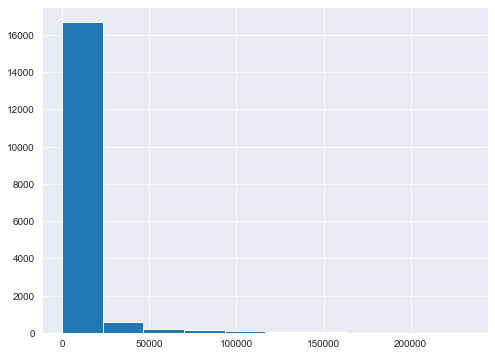

In [34]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist()

From the output, we can see that most of the movies have received less than 25000 ratings. While the number of movies having more than 50000 ratings is very low.

Now we'll plot a histogram for average ratings. Here is the code to do so:

Let's now do the same thing with "Cust_Id"

In [37]:
data.groupby('Cust_Id')['Rating'].count().sort_values(ascending=False).head()

Cust_Id
305344     17653
387418     17436
2439493    16565
1664010    15813
2118461    14831
Name: Rating, dtype: int64

In [39]:
data.groupby('Cust_Id')['Rating'].mean().head()

Cust_Id
6     3.418530
7     4.011351
8     4.214286
10    3.392308
25    3.481481
Name: Rating, dtype: float64

In [40]:
customer_mean_count = pd.DataFrame(data.groupby('Cust_Id')['Rating'].mean())
customer_mean_count['rating_counts'] = pd.DataFrame(data.groupby('Cust_Id')['Rating'].count())
customer_mean_count.head()

,Rating,rating_counts
Cust_Id,,
6,3.418530,626
7,4.011351,881
8,4.214286,98
10,3.392308,260
25,3.481481,27


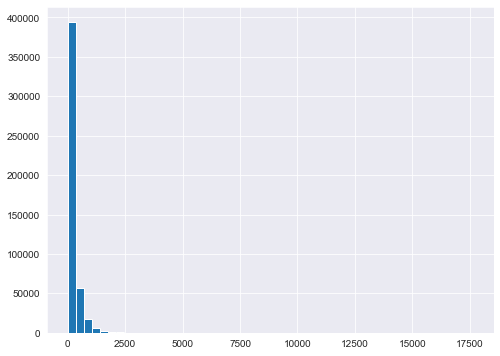

In [42]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
customer_mean_count['rating_counts'].hist(bins=50)

From the output, we can see that most of the customer gave the less ratings (same reasoning as "Movie_Id").

Since the data is super huge, we had many times a memory error, so according to the results shown above, we opted for data reducing by removing :

    *Less reviews movies
    *Customer who give too less ratings

In [47]:
ratings_mean_count.index = ratings_mean_count.index.map(int)
movie_benchmark = round(ratings_mean_count['rating_counts'].quantile(0.7),0)
drop_movie_list = ratings_mean_count[ratings_mean_count['rating_counts'] < movie_benchmark].index

print('Less reviews movies: {}'.format(movie_benchmark))

customer_mean_count.index = customer_mean_count.index.map(int)
cust_benchmark = round(customer_mean_count['rating_counts'].quantile(0.7),0)
drop_cust_list = customer_mean_count[customer_mean_count['rating_counts'] < cust_benchmark].index

print('Customers who give too less ratings: {}'.format(cust_benchmark))

Less reviews movies: 1948.0
Customers who give too less ratings: 211.0


Now, lets compare the sizes of the original data and the new one

In [48]:
print('Original Data: {}'.format(data.shape))
data = data[~data['Movie_Id'].isin(drop_movie_list)]
data = data[~data['Cust_Id'].isin(drop_cust_list)]
print('New Data: {}'.format(data.shape))

Original Data: (100480507, 3)
New Data: (71833509, 3)


## Recommendation models

Our Data is loaded and cleaned, so let's get into the recommendation system.
We will implement a first model called Collaborative Filtering and seconde one based on Pearsons' R correlations.

### Collaborative Filtering

Collaborative Filtering involves suggesting movies to the users that are based on collecting preferences from many other users. 
For example, if a user A likes to watch action films and so does user B, then the movies that the user B will watch 
in the future will be recommended to A and vice-versa. 
Therefore, recommending movies is dependent on creating a relationship of similarity between the two users. 

Let's build our model using SVD algorithm.

We will use the train_test_split() to sample a trainset and a testset with given sizes, and use the accuracy metric of our chosing. we’ll need to use the fit() method which will train the algorithm on the trainset, and the test() method which will return the predictions made from the testset:

In [72]:
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# sample random trainset and testset
# test set is made of 25% of the ratings.
#reader=Reader()
#dataBis = Dataset.load_from_df(data, reader)

#trainset, testset = train_test_split(data, test_size=.25)
reader=Reader()
#trainsetBis = Dataset.load_from_df(trainset[:1000000], reader)
#testsetBis = Dataset.load_from_df(testset[:100000], reader)

dataBis = Dataset.load_from_df(data[['Cust_Id', 'Movie_Id', 'Rating'][:100]], reader)

trainset = dataBis.build_full_trainset()
algo = SVD()
algo.train(trainset)
# We'll use the famous SVD algorithm.
#algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
#algo.fit(trainsetBis)
#predictions = algo.test(testsetBis)

# Then compute RMSE
#accuracy.rmse(predictions)

MemoryError: 

In [73]:
reader = Reader()

#get just top 100K rows for faster run time
data_BIS = Dataset.load_from_df(data[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data_BIS, measures=['RMSE', 'MAE'])

MemoryError: 

In [57]:
testset.head()

,Cust_Id,Rating,Movie_Id
26100669,121921,4.0,4857
66061163,1561553,1.0,12084
43222274,299218,3.0,7627
79783342,1135596,4.0,14407
85071885,1030762,3.0,15124


In [52]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

AttributeError: 'DataFrame' object has no attribute 'global_mean'

Us we can see the RMSE is approximatly equal to 1, we can deduce that our model is good enough.
Also according to the accuracy we deduce that our model predict correctly the score for 96% of users.

### Prediction

Let's predict which movies user 785314 would love to watch but let's first see what he liked in the past

In [31]:
user_785314 = data[(data['Cust_Id'] == 785314) & (data['Rating'] == 5)]
user_785314 = user_785314.set_index('Movie_Id')
user_785314 = user_785314.join(data_title)['Name']
print(user_785314)

Movie_Id
175                             Reservoir Dogs
311                                    Ed Wood
329                                      Dogma
331                                Chasing Amy
788                                     Clerks
                         ...                  
17474            My Fair Lady: Special Edition
17482                                 Clueless
17560                             Ghostbusters
17627    Harry Potter and the Sorcerer's Stone
17764                      Shakespeare in Love
Name: Name, Length: 136, dtype: object


In [33]:
user_785314 = data_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
dataBis = Dataset.load_from_df(data[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = dataBis.build_full_trainset()
svd.train(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

AttributeError: 'SVD' object has no attribute 'train'